In [ ]:
from huggingface_hub import hf_hub_download

!pip install -U huggingface_hub
from huggingface_hub import login
login()  

zip_path = hf_hub_download(repo_id="rimtyouss/SPEECH_TO_TEXT", repo_type="dataset", filename="train-clean-100.zip")
dev_path = hf_hub_download(repo_id="rimtyouss/SPEECH_TO_TEXT", repo_type="dataset", filename="dev-clean.tar.gz")
test_path = hf_hub_download(repo_id="rimtyouss/SPEECH_TO_TEXT", repo_type="dataset", filename="test-clean.tar.gz")


In [13]:
import zipfile
import tarfile
import os

zip_extract_to = "/content/LibriSpeech/LibriSpeech/"
os.makedirs(zip_extract_to, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(zip_extract_to)

tar_extract_to = "/content/LibriSpeech/"
for tar_file in [dev_path, test_path]:
    with tarfile.open(tar_file, "r:gz") as tar:
        tar.extractall(path=tar_extract_to)


In [14]:
import os
import torchaudio

def load_librispeech_data(path):
    all_data = []
    for speaker in os.listdir(path):
        speaker_path = os.path.join(path, speaker)
        if not os.path.isdir(speaker_path):
            continue
        for chapter in os.listdir(speaker_path):
            chapter_path = os.path.join(speaker_path, chapter)
            if not os.path.isdir(chapter_path):
                continue

            #  transcripciones
            trans_file = os.path.join(chapter_path, f"{speaker}-{chapter}.trans.txt")
            if not os.path.exists(trans_file):
                continue
            with open(trans_file, "r") as f:
                transcriptions = {
                    line.split(" ")[0]: " ".join(line.strip().split(" ")[1:])
                    for line in f.readlines()
                }

            # Cargar audios y emparejar con texto
            for file in os.listdir(chapter_path):
                if file.endswith(".flac"):
                    file_path = os.path.join(chapter_path, file)
                    waveform, sample_rate = torchaudio.load(file_path)
                    utt_id = file.replace(".flac", "")
                    if utt_id in transcriptions:
                        all_data.append((waveform, sample_rate, transcriptions[utt_id]))

    return all_data



In [15]:
train_data = load_librispeech_data("/content/LibriSpeech/LibriSpeech/train-clean-100")
valid_data = load_librispeech_data("/content/LibriSpeech/LibriSpeech/dev-clean")
test_data  = load_librispeech_data("/content/LibriSpeech/LibriSpeech/test-clean")


In [16]:
# Rutas
train_path = "/content/LibriSpeech/LibriSpeech/train-clean-100"
valid_path = "/content/LibriSpeech/LibriSpeech/dev-clean"
test_path  = "/content/LibriSpeech/LibriSpeech/test-clean"

# Cargar los datos
train_data = load_librispeech_data(train_path)
valid_data = load_librispeech_data(valid_path)
test_data  = load_librispeech_data(test_path)

# Mostrar resumen
print(f"rain: {len(train_data)} muestras")
print(f"Valid: {len(valid_data)} muestras")
print(f"Test : {len(test_data)} muestras")


rain: 4178 muestras
Valid: 2703 muestras
Test : 2620 muestras


In [2]:
from torch.utils.data import Dataset
import torchaudio.transforms as T
import torch

class Seq2SeqSpeechDataset(Dataset):
    def __init__(self, data, char_to_index, sample_rate=16000, n_mfcc=13):
        self.data = data
        self.char_to_index = char_to_index
        self.sample_rate = sample_rate
        self.transform = T.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,
            melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23}
        )
        self.sos_token = char_to_index["<SOS>"]
        self.eos_token = char_to_index["<EOS>"]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        waveform, sample_rate, text = self.data[idx]
        mfcc = self.transform(waveform).squeeze(0).transpose(0, 1)

        # Convertir texto en índices con tokens espec
        text_indices = [self.sos_token] + [self.char_to_index.get(c, self.char_to_index["<UNK>"]) for c in text] + [self.eos_token]
        target = torch.tensor(text_indices, dtype=torch.long)

        return mfcc, target


In [3]:
def seq2seq_collate_fn(batch):
    mfccs, targets = zip(*batch)

    # Longitudes reales
    input_lengths = torch.tensor([mfcc.shape[0] for mfcc in mfccs])
    target_lengths = torch.tensor([target.shape[0] for target in targets])

    # Padding
    padded_inputs = torch.nn.utils.rnn.pad_sequence(mfccs, batch_first=True)
    padded_targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=char_to_index["<PAD>"])

    return padded_inputs, padded_targets, input_lengths, target_lengths


In [17]:
# Extraer caracteres unicos
all_text = " ".join([text for _, _, text in train_data])
unique_chars = sorted(set(all_text.replace(" ", "") + " "))

# Tokens especiales
special_tokens = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]

# Crear diccionario
char_to_index = {token: i for i, token in enumerate(special_tokens)}
for char in unique_chars:
    if char not in char_to_index:
        char_to_index[char] = len(char_to_index)

index_to_char = {i: c for c, i in char_to_index.items()}

print("Vocabulario listo con tokens especiales.")
print(f"Total tokens: {len(char_to_index)}")


Vocabulario listo con tokens especiales.
Total tokens: 32


In [18]:
from torch.utils.data import DataLoader

train_dataset = Seq2SeqSpeechDataset(train_data, char_to_index)
valid_dataset = Seq2SeqSpeechDataset(valid_data, char_to_index)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=seq2seq_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=seq2seq_collate_fn)


In [4]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, enc_hidden_dim, enc_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, enc_hidden_dim, num_layers=enc_layers,
                            bidirectional=True, batch_first=True, dropout=dropout)

    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, (hidden, cell) = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        return outputs, hidden, cell


# Módulo de Atención
Ayuda al decoder a "enfocarse" en partes importantes de la salida del encoder en cada paso

In [5]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim * 2 + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask):
        batch_size, src_len, _ = encoder_outputs.shape
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        scores = self.v(energy).squeeze(2)
        scores = scores.masked_fill(mask == 0, -1e10)
        return torch.softmax(scores, dim=1)


In [6]:
class Decoder(nn.Module):
    def __init__(self, output_dim, enc_hidden_dim, dec_hidden_dim, attention, dropout=0.1):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, dec_hidden_dim)
        self.rnn = nn.LSTM(enc_hidden_dim * 2 + dec_hidden_dim, dec_hidden_dim, num_layers=2, batch_first=True)
        self.fc_out = nn.Linear(enc_hidden_dim * 2 + dec_hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs, mask):
        if input.dim() == 1:
          input = input.unsqueeze(1)

        embedded = self.dropout(self.embedding(input))

        attn_weights = self.attention(hidden[-1], encoder_outputs, mask)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)

        rnn_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))

        prediction = self.fc_out(torch.cat((output.squeeze(1), context.squeeze(1), embedded.squeeze(1)), dim=1))
        return prediction, hidden, cell, attn_weights


In [7]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.pad_idx = pad_idx

    def create_mask(self, src, src_lengths):
        src_lengths = src_lengths.to(src.device)
        return torch.arange(src.size(1), device=src.device).unsqueeze(0) < src_lengths.unsqueeze(1)

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.shape
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(src, src_lengths)

        def transform(h):
            if h.size(0) == 2:
                return h[0:1] + h[1:2]
            elif h.size(0) % 2 == 0:
                return torch.stack([h[i] + h[i + 1] for i in range(0, h.size(0), 2)])
            else:
                return h

        hidden = transform(hidden)
        cell = transform(cell)

        input = trg[:, 0]
        mask = self.create_mask(src, src_lengths)

        for t in range(1, trg_len):
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_outputs, mask)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs


In [8]:
def train(model, loader, optimizer, criterion, clip=1):
    model.train()
    epoch_loss = 0

    for src, trg, src_lengths, trg_lengths in loader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src, src_lengths, trg)

        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, trg, src_lengths, trg_lengths in loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, src_lengths, trg, teacher_forcing_ratio=0.0)

            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(loader)


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INPUT_DIM = 13
ENC_HIDDEN_DIM = 256
DEC_HIDDEN_DIM = 256
ENC_LAYERS = 2
PAD_IDX = char_to_index["<PAD>"]
OUTPUT_DIM = len(char_to_index)

encoder = Encoder(input_dim=INPUT_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, enc_layers=ENC_LAYERS)
attention = Attention(enc_hidden_dim=ENC_HIDDEN_DIM, dec_hidden_dim=DEC_HIDDEN_DIM)
decoder = Decoder(output_dim=OUTPUT_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, dec_hidden_dim=DEC_HIDDEN_DIM, attention=attention)

seq2seq_model = Seq2Seq(encoder, decoder, PAD_IDX, device).to(device)

# Optimizador y función de pérdida
optimizer = torch.optim.Adam(seq2seq_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)


In [ ]:

N_EPOCHS = 10
train_losses_attention = []
val_losses_attention = []

for epoch in range(N_EPOCHS):
    train_loss = train(seq2seq_model, train_loader, optimizer, criterion)
    val_loss = evaluate(seq2seq_model, valid_loader, criterion)

    train_losses_attention.append(train_loss)
    val_losses_attention.append(val_loss)

    print(f"Epoch {epoch+1}/{N_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/10 | Train Loss: 2.5804 | Val Loss: 2.9901
Epoch 2/10 | Train Loss: 2.4717 | Val Loss: 2.9125
Epoch 3/10 | Train Loss: 2.4319 | Val Loss: 2.9475
Epoch 4/10 | Train Loss: 2.4075 | Val Loss: 2.9365
Epoch 5/10 | Train Loss: 2.3857 | Val Loss: 2.9198
Epoch 6/10 | Train Loss: 2.3753 | Val Loss: 2.9802
Epoch 7/10 | Train Loss: 2.3563 | Val Loss: 2.8928
Epoch 8/10 | Train Loss: 2.3430 | Val Loss: 2.9895
Epoch 9/10 | Train Loss: 2.3359 | Val Loss: 2.9119
Epoch 10/10 | Train Loss: 2.3139 | Val Loss: 2.9820


In [ ]:
torch.save(seq2seq_model.state_dict(), "attention_seq2seq_model.pth")
print("Modelo guardado como attention_seq2seq_model.pth")


Modelo guardado como attention_seq2seq_model.pth


In [ ]:
import random
import torch

# Función greedy
def greedy_decode_seq2seq(model, input_tensor, input_length, max_len=150):
    model.eval()
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(input_tensor, input_length)

        def transform(h):
            if h.size(0) == 2:
                return h[0:1] + h[1:2]
            elif h.size(0) % 2 == 0:
                return torch.stack([h[i] + h[i + 1] for i in range(0, h.size(0), 2)])
            else:
                return h

        hidden = transform(hidden)
        cell = transform(cell)

        input_token = torch.tensor([char_to_index["<SOS>"]], device=device).view(1)

        mask = model.create_mask(input_tensor, input_length)

        decoded_indices = []
        for _ in range(max_len):
            output, hidden, cell, _ = model.decoder(input_token, hidden, cell, encoder_outputs, mask)
            top1 = output.argmax(1)
            if top1.item() == char_to_index["<EOS>"]:
                break
            decoded_indices.append(top1.item())
            input_token = top1.unsqueeze(0)



    return decoded_indices





Texto real limpio:      IT WAS SPECIALLY SUITED FOR A TRIAL PLANT ALSO IN THE EARLY DAYS WHEN A YIELD OF SIX OR EIGHT LAMPS TO THE HORSE POWER WAS CONSIDERED SUBJECT FOR CONGRATULATION
Texto predicho limpio:  IT WAS SO E 

Longitud real:   160
Longitud predicha: 12

WER : 0.9333


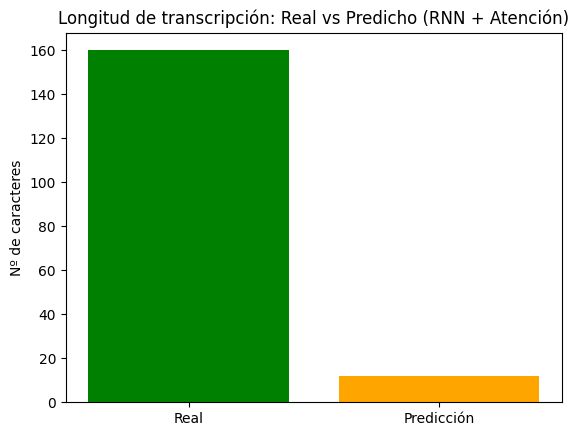

In [ ]:
from torchaudio.transforms import MFCC
from jiwer import wer
import matplotlib.pyplot as plt
import random
import re

# Elegir muestra aleatoria
sample_idx = random.randint(0, len(test_data) - 1)
waveform, sample_rate, true_text = test_data[sample_idx]

# Convertir a MFCC
transform = MFCC(sample_rate=16000, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23})
mfcc = transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).to(device)
input_length = torch.tensor([mfcc.shape[1]]).to(device)

# Inferencia
predicted_indices = greedy_decode_seq2seq(seq2seq_model, mfcc, input_length)
predicted_text = "".join([index_to_char.get(i, "") for i in predicted_indices])

# quitar repeticiones consecutivas
def remove_repetitions(text):
    return ''.join([char for i, char in enumerate(text) if i == 0 or char != text[i-1]])

predicted_text = remove_repetitions(predicted_text)

# Limpiar texto
true_text_clean = ''.join([c for c in true_text.upper() if c in char_to_index])
predicted_text_clean = ''.join([c for c in predicted_text.upper() if c in char_to_index])


# Calcular WER
wer_score = wer(true_text_clean.lower(), predicted_text_clean.lower())

# Mostrar resultados
print(f"\nTexto real limpio:      {true_text_clean}")
print(f"Texto predicho limpio:  {predicted_text_clean}")
print(f"\nLongitud real:   {len(true_text_clean)}")
print(f"Longitud predicha: {len(predicted_text_clean)}")
print(f"\nWER : {wer_score:.4f}")

plt.bar(["Real", "Predicción"], [len(true_text_clean), len(predicted_text_clean)], color=["green", "orange"])
plt.title("Longitud de transcripción: Real vs Predicho (RNN + Atención)")
plt.ylabel("Nº de caracteres")
plt.show()



Texto real limpio:      SAID MISTER IRWINE WITH HIS STATELY CORDIALITY
Texto predicho limpio:  SINCE THE IS IN IN IN IN THE IT IS THE IE E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E 

Longitud real:   46
Longitud predicha: 108

WER : 6.4286


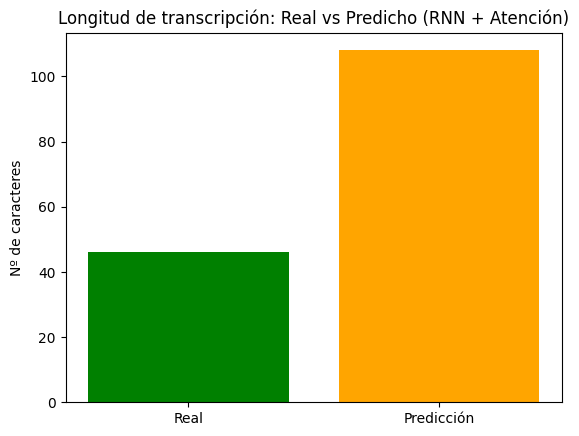

In [ ]:
from torchaudio.transforms import MFCC
from jiwer import wer
import matplotlib.pyplot as plt
import random

sample_idx = random.randint(0, len(test_data) - 1)
waveform, sample_rate, true_text = test_data[sample_idx]

transform = MFCC(sample_rate=16000, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23})
mfcc = transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).to(device)
input_length = torch.tensor([mfcc.shape[1]]).to(device)

predicted_indices = greedy_decode_seq2seq(seq2seq_model, mfcc, input_length)
predicted_text = "".join([index_to_char.get(i, "") for i in predicted_indices])

def remove_repetitions(text):
    return ''.join([char for i, char in enumerate(text) if i == 0 or char != text[i-1]])

predicted_text = remove_repetitions(predicted_text)

true_text_clean = ''.join([c for c in true_text.upper() if c in char_to_index])
predicted_text_clean = ''.join([c for c in predicted_text.upper() if c in char_to_index])

wer_score = wer(true_text_clean.lower(), predicted_text_clean.lower())

print(f"\nTexto real limpio:      {true_text_clean}")
print(f"Texto predicho limpio:  {predicted_text_clean}")
print(f"\nLongitud real:   {len(true_text_clean)}")
print(f"Longitud predicha: {len(predicted_text_clean)}")
print(f"\nWER : {wer_score:.4f}")

plt.bar(["Real", "Predicción"], [len(true_text_clean), len(predicted_text_clean)], color=["green", "orange"])
plt.title("Longitud de transcripción: Real vs Predicho (RNN + Atención)")
plt.ylabel("Nº de caracteres")
plt.show()



Mejor muestra encontrada (WER = 0.6667):
Índice muestra: 828
Texto real     : HE HAD GOT INTO HER COURTYARD
Texto predicho : HE HAD NOT KNOW HE AE 
Longitud real  : 29
Longitud predicha: 22


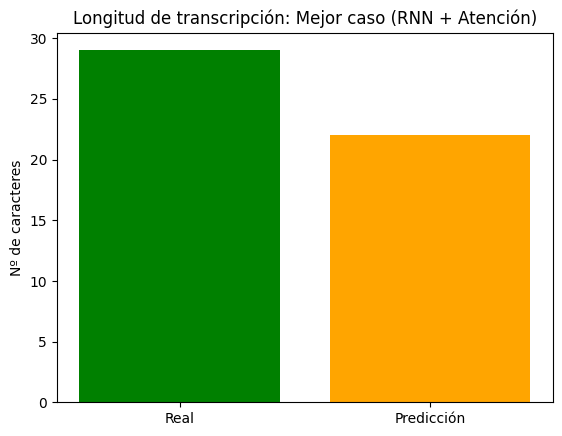

In [ ]:
from torchaudio.transforms import MFCC
from jiwer import wer
import matplotlib.pyplot as plt
import torch
import random

transform = MFCC(sample_rate=16000, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23})

def remove_repetitions(text):
    return ''.join([char for i, char in enumerate(text) if i == 0 or char != text[i-1]])

best_wer = float('inf')
best_result = {}

for _ in range(500):
    sample_idx = random.randint(0, len(test_data) - 1)
    waveform, sample_rate, true_text = test_data[sample_idx]

    mfcc = transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).to(device)
    input_length = torch.tensor([mfcc.shape[1]]).to(device)

    predicted_indices = greedy_decode_seq2seq(seq2seq_model, mfcc, input_length)
    predicted_text = "".join([index_to_char.get(i, "") for i in predicted_indices])
    predicted_text = remove_repetitions(predicted_text)

    true_text_clean = ''.join([c for c in true_text.upper() if c in char_to_index])
    predicted_text_clean = ''.join([c for c in predicted_text.upper() if c in char_to_index])

    current_wer = wer(true_text_clean.lower(), predicted_text_clean.lower())

    if current_wer < best_wer:
        best_wer = current_wer
        best_result = {
            "idx": sample_idx,
            "true_text": true_text_clean,
            "pred_text": predicted_text_clean,
            "len_true": len(true_text_clean),
            "len_pred": len(predicted_text_clean),
            "wer": current_wer
        }

# mejor resultado
print(f"\nMejor muestra encontrada (WER = {best_result['wer']:.4f}):")
print(f"Índice muestra: {best_result['idx']}")
print(f"Texto real     : {best_result['true_text']}")
print(f"Texto predicho : {best_result['pred_text']}")
print(f"Longitud real  : {best_result['len_true']}")
print(f"Longitud predicha: {best_result['len_pred']}")

plt.bar(["Real", "Predicción"], [best_result['len_true'], best_result['len_pred']], color=["green", "orange"])
plt.title("Longitud de transcripción: Mejor caso (RNN + Atención)")
plt.ylabel("Nº de caracteres")
plt.show()



Mejor muestra encontrada con WER <= 0.5:
Intentos: 159
WER: 0.6667
Índice muestra: 309
Texto real     : IT IS A DUTY SAID I
Texto predicho : IT IS I A 
Longitud real  : 19
Longitud predicha: 10


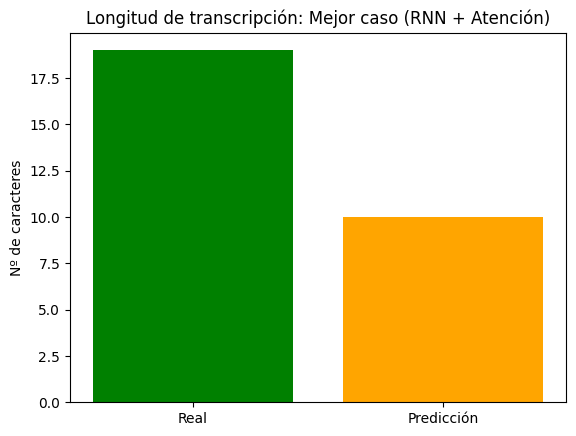

In [ ]:
from torchaudio.transforms import MFCC
from jiwer import wer
import matplotlib.pyplot as plt
import torch
import random

transform = MFCC(sample_rate=16000, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23})

def remove_repetitions(text):
    return ''.join([char for i, char in enumerate(text) if i == 0 or char != text[i-1]])

best_wer = float('inf')
best_result = {}
attempts = 0
max_attempts = 1000

while best_wer > 0.5 and attempts < max_attempts:
    sample_idx = random.randint(0, len(test_data) - 1)
    waveform, sample_rate, true_text = test_data[sample_idx]

    mfcc = transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).to(device)
    input_length = torch.tensor([mfcc.shape[1]]).to(device)

    predicted_indices = greedy_decode_seq2seq(seq2seq_model, mfcc, input_length)
    predicted_text = "".join([index_to_char.get(i, "") for i in predicted_indices])
    predicted_text = remove_repetitions(predicted_text)

    true_text_clean = ''.join([c for c in true_text.upper() if c in char_to_index])
    predicted_text_clean = ''.join([c for c in predicted_text.upper() if c in char_to_index])

    current_wer = wer(true_text_clean.lower(), predicted_text_clean.lower())
    attempts += 1

    if current_wer < best_wer:
        best_wer = current_wer
        best_result = {
            "idx": sample_idx,
            "true_text": true_text_clean,
            "pred_text": predicted_text_clean,
            "len_true": len(true_text_clean),
            "len_pred": len(predicted_text_clean),
            "wer": current_wer,
            "attempts": attempts
        }

# mejor resultado
print(f"\nMejor muestra encontrada con WER <= 0.5:")
print(f"Intentos: {best_result['attempts']}")
print(f"WER: {best_result['wer']:.4f}")
print(f"Índice muestra: {best_result['idx']}")
print(f"Texto real     : {best_result['true_text']}")
print(f"Texto predicho : {best_result['pred_text']}")
print(f"Longitud real  : {best_result['len_true']}")
print(f"Longitud predicha: {best_result['len_pred']}")

plt.bar(["Real", "Predicción"], [best_result['len_true'], best_result['len_pred']], color=["green", "orange"])
plt.title("Longitud de transcripción: Mejor caso (RNN + Atención)")
plt.ylabel("Nº de caracteres")
plt.show()


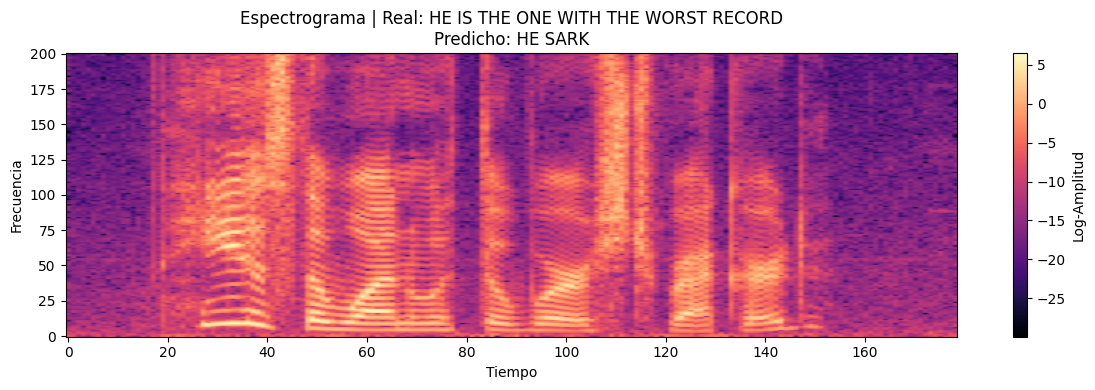

In [ ]:
import torchaudio
import matplotlib.pyplot as plt
import random

# muestra del test
sample_idx = random.randint(0, len(test_data) - 1)
waveform, sample_rate, true_text = test_data[sample_idx]

# Espectrograma
spectrogram = torchaudio.transforms.Spectrogram()(waveform)

# Predicción del modelo
transform = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=13)
mfcc = transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).to(device)
input_length = torch.tensor([mfcc.shape[1]]).to(device)

predicted_indices = greedy_decode_seq2seq(seq2seq_model, mfcc, input_length)
predicted_text = "".join([index_to_char.get(i, "") for i in predicted_indices])

# espectrograma + transcripciones
plt.figure(figsize=(12, 4))
plt.imshow(spectrogram.log2()[0,:,:].numpy(), origin='lower', aspect='auto', cmap='magma')
plt.title(f"Espectrograma | Real: {true_text}\nPredicho: {predicted_text}")
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")
plt.colorbar(label="Log-Amplitud")
plt.tight_layout()
plt.show()


In [20]:
seq2seq_model.load_state_dict(torch.load("attention_seq2seq_model.pth"))
seq2seq_model.eval()


Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(13, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(32, 256)
    (rnn): LSTM(768, 256, num_layers=2, batch_first=True)
    (fc_out): Linear(in_features=1024, out_features=32, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [22]:
# Número total de parámetros
total_params = sum(p.numel() for p in seq2seq_model.parameters())

# Número de parámetros entrenables
trainable_params = sum(p.numel() for p in seq2seq_model.parameters() if p.requires_grad)

print(f"Parámetros totales: {total_params:,}")


Parámetros totales: 3,947,040
